In [24]:
import pandas as pd
import sqlite3
query = 'SELECT * FROM sparkling_wine'

conn = sqlite3.connect('wine_database.db')
cursor = conn.cursor()
df = pd.read_sql_query(query, conn)
df['Name'] = df['Name'].str.encode('iso-8859-1').str.decode('utf-8')
df['Region'] = df['Region'].str.encode('iso-8859-1').str.decode('utf-8')
df['Winery'] = df['Winery'].str.encode('iso-8859-1').str.decode('utf-8')
df

,Name,Country,Region,Winery,Rating,Price,Year
0,Crémant de Loire Brut 2017,France,Crémant de Loire,Langlois-Chateau,3.9,14.41,2017
1,Vicar's Choice Sauvignon Blanc Bubbles 2019,New Zealand,Marlborough,Saint Clair,4.2,11.90,2019
2,Athesis Brut 2016,Italy,Südtirol - Alto Adige,Kettmeir,4.0,21.50,2016
3,Riesling Extra Brut 2015,Germany,Baden,Griesel & Compagnie,4.0,22.13,2015
4,Brut 2012,United States,Anderson Valley,Roederer Estate,3.9,57.51,2012
...,...,...,...,...,...,...,...
274,Grand Vintage Brut Champagne 2009,France,Champagne,Moët & Chandon,4.2,67.29,2009
275,Cristal Brut Champagne (Millésimé) 2007,France,Champagne,Louis Roederer,4.6,223.23,2007
276,La Grande Année Brut Champagne 2007,France,Champagne,Bollinger,4.4,119.00,2007
277,Comtes de Champagne Blanc de Blancs 2006,France,Champagne,Taittinger,4.5,145.19,2006


In [26]:
df.to_csv('scraped_Sparkling.csv', index=False)

In [28]:

Counrty_dummies = pd.get_dummies(df["Country"])
Region_dummies = pd.get_dummies(df["Region"])
Winery_dummies = pd.get_dummies(df["Winery"])
empty_df = df.drop(columns=["Name", "Country", "Region", "Winery"])

In [30]:
df_scaled = pd.concat([empty_df, Region_dummies, Counrty_dummies, Winery_dummies], axis =1)
df_scaled.head()

,Rating,Price,Year,'61 Franciacorta Nature 2012,'Giulio Ferrari' Riserva del Fondatore 2007,'Giulio Ferrari' Riserva del Fondatore 2008,'Giulio Ferrari' Riserva del Fondatore Rosé 2006,Alexandra Champagne Rosé (Grande Cuvée) 2004,Alta Langa Contessa Rosa Rosé 2012,Amour de Deutz Millésime Brut Champagne 2007,...,Vardon Kennett,Veuve A. Devaux,Veuve Clicquot,Vietti,Vilarnau,Villa Maria,Villa Sandi,Weingüter Wegeler,Winzervereinigung Freyburg-Unstrut,Zonin
0,3.9,14.41,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.2,11.90,2019,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,21.50,2016,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,22.13,2015,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.9,57.51,2012,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [33]:
from sklearn.model_selection import train_test_split
X = df_scaled.drop(columns="Rating")
y = df_scaled["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
model.fit(X, y)

LinearRegression()

In [35]:
LinearRegression()

LinearRegression()

In [36]:
predicted_y_values = model.predict(X)

In [37]:
copy_df = df.copy()

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
score = model.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print releveant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 1.0.
The r2 is 1.0.
The mean squared error is 1.6266912700576115e-27.
The root mean squared error is 4.033226090932185e-14.
The standard deviation is 0.28456569346063876.


In [39]:
Region_ratings = df.groupby("Region")["Rating"].mean()
Region_ratings

Region
Alta Langa                           3.750000
Anderson Valley                      4.100000
Asti                                 3.600000
Baden                                3.940000
Blanquette de Limoux                 3.700000
Brachetto d'Acqui                    4.000000
Burgenland                           4.300000
Cava                                 3.835714
Champagne                            4.338095
Champagne Grand Cru                  4.000000
Champagne Grand Cru 'Aÿ'             4.333333
Champagne Grand Cru 'Bouzy'          4.300000
Champagne Premier Cru                4.087500
Colli Orientali del Friuli           4.100000
Conegliano-Valdobbiadene Prosecco    3.872727
Contea di Sclafani                   3.900000
Crémant de Limoux                    3.600000
Crémant de Loire                     3.900000
Crémant du Jura                      3.700000
Douro                                4.050000
Emilia                               4.000000
Franciacorta               

In [40]:
Year_ratings = df.groupby("Year")["Rating"].mean()

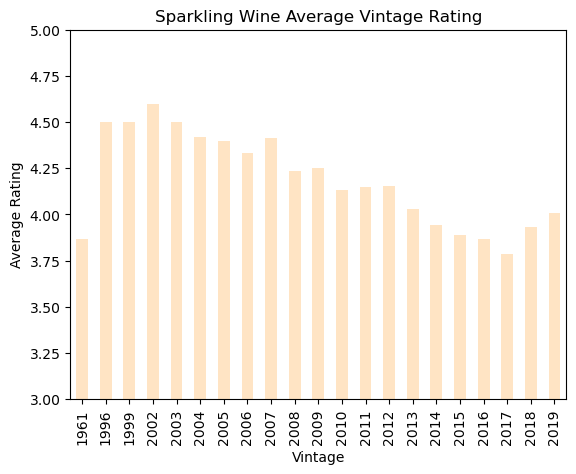

In [41]:
import matplotlib.pyplot as plt
plot_pandas = Year_ratings.plot.bar(color='bisque')
plt.title("Sparkling Wine Average Vintage Rating")
plt.xlabel('Vintage')
plt.ylabel('Average Rating')
plt.ylim(3, 5)
plt.show()

In [42]:
Rating_price = df.groupby("Rating")["Price"].mean()

C:\Users\Carrie Work\AppData\Local\Temp\ipykernel_24800\9271193.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))


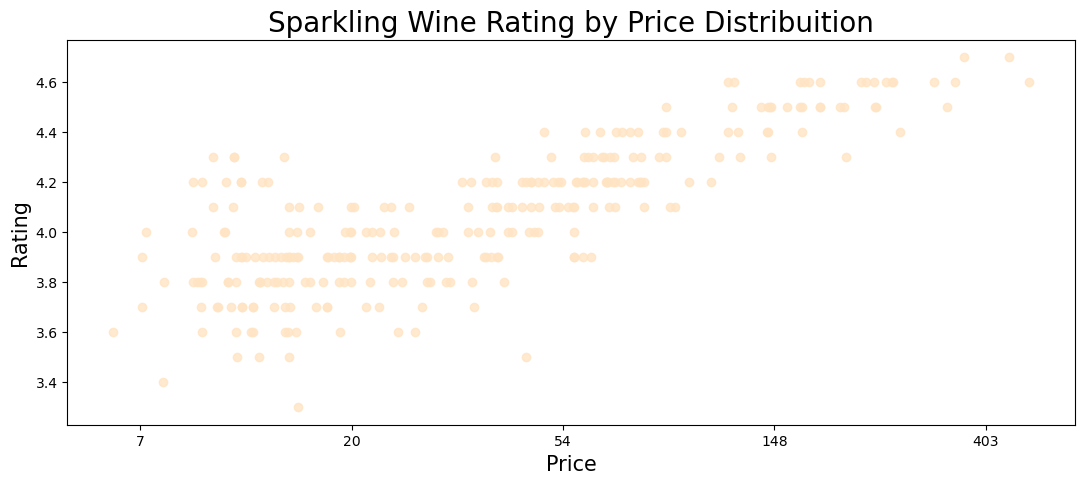

In [43]:
import seaborn as sns
plt.figure(figsize=(13,5))

graph = sns.regplot(x=np.log(df['Price']), y='Rating', 
                    data=df, fit_reg=False, color='bisque')
graph.set_title("Sparkling Wine Rating by Price Distribuition", fontsize=20)
graph.set_xlabel("Price", fontsize= 15)
graph.set_ylabel("Rating", fontsize= 15)
graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))
plt.savefig('Sparkling_Price.png')
plt.show()

In [44]:
Country_ratings = df.groupby("Country")["Rating"].mean()

In [45]:
Country_price = df.groupby("Country")["Price"].mean()